In [0]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

### Data Preparation

In [0]:
# Cargar dataset 
df = spark.table("hive_metastore.default.churn_modelling_6_csv")
df.write.mode("overwrite").option("header", True).csv("/dbfs/FileStore/hive_metastore.default.churn_modelling_6_csv")
df = df.toPandas()

In [0]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int32  
 1   CustomerId       10000 non-null  int32  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int32  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int32  
 7   Tenure           10000 non-null  int32  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int32  
 10  HasCrCard        10000 non-null  int32  
 11  IsActiveMember   10000 non-null  int32  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int32  
dtypes: float64(2), int32(9), object(3)
memory usage: 742.3+ KB


In [0]:
# Checar valores faltantes
missing_values = df.isna().sum() / len(df)
missing_values

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [0]:
#Eliminar columnas que no se necesitan para el modelo
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


### Exploratory Data Analysis

In [0]:
#Checar la distribución de clases de la columna target
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [0]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


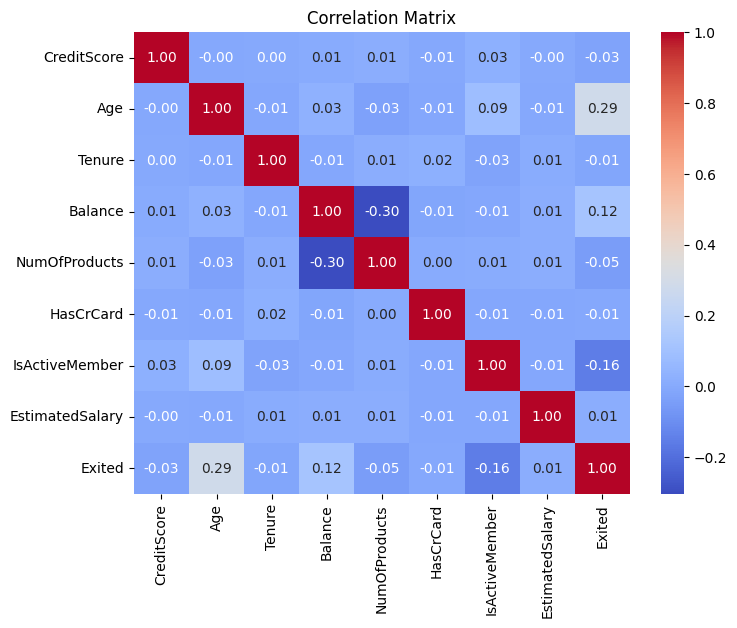

In [0]:
# Análisis de correlación
numeric_columns = df.select_dtypes(include=['int32', 'float64'])
corr_matrix = numeric_columns.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

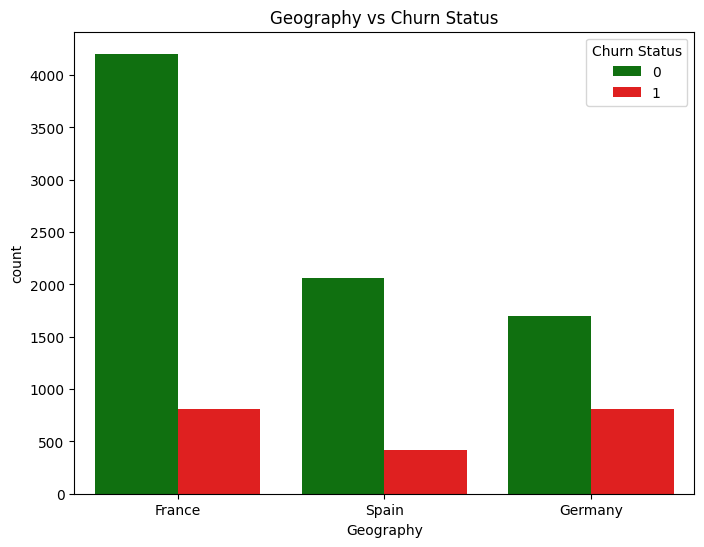

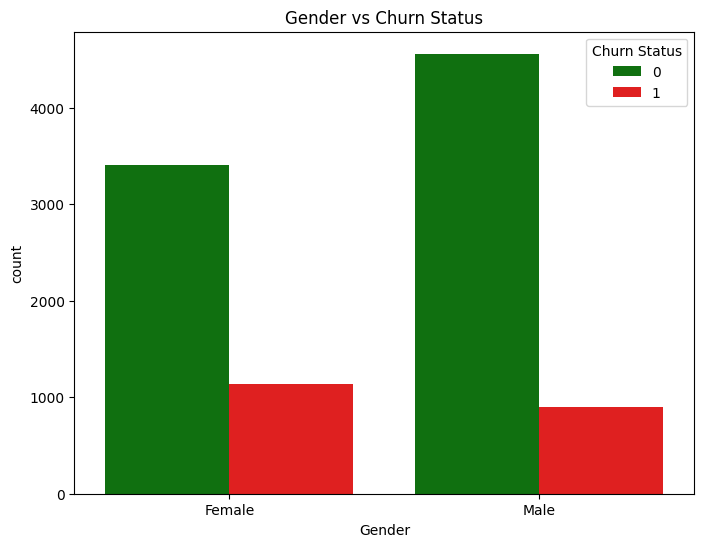

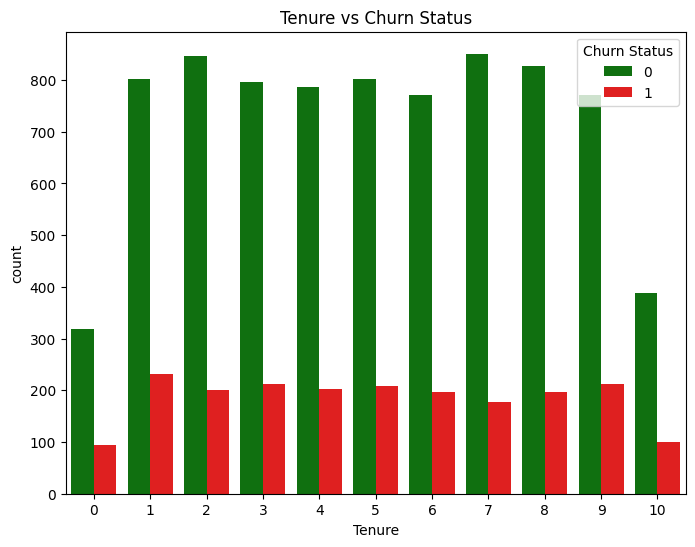

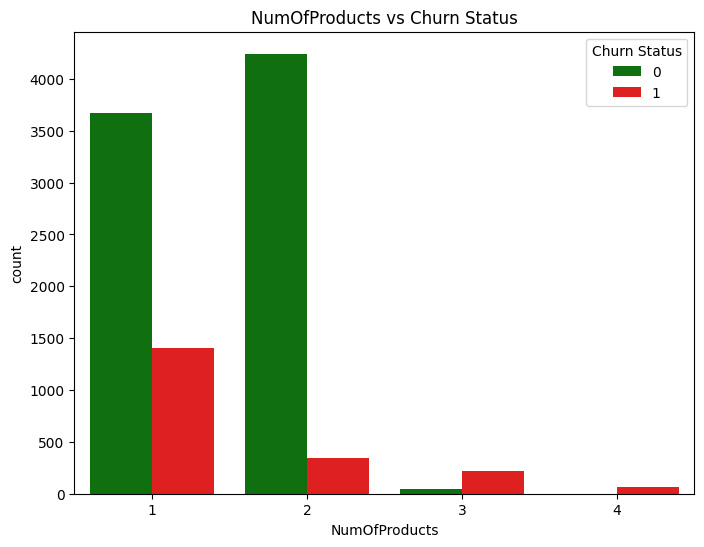

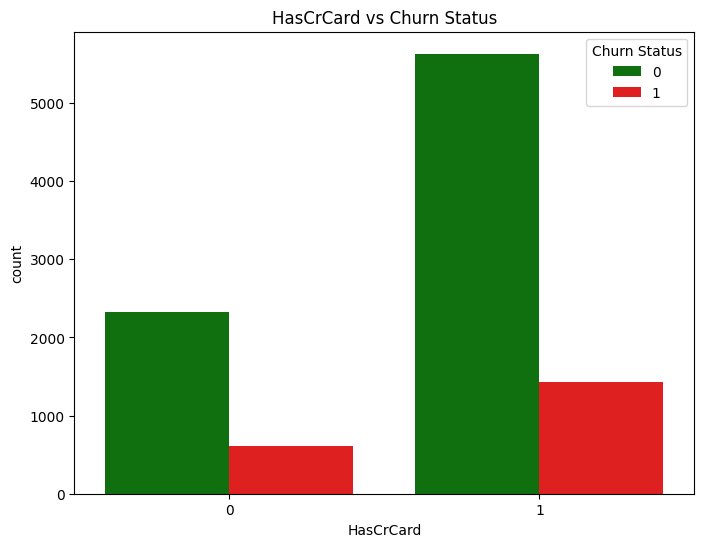

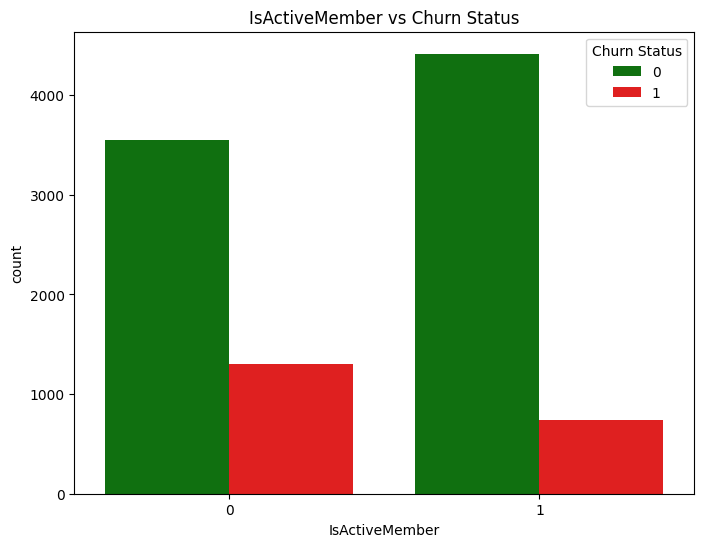

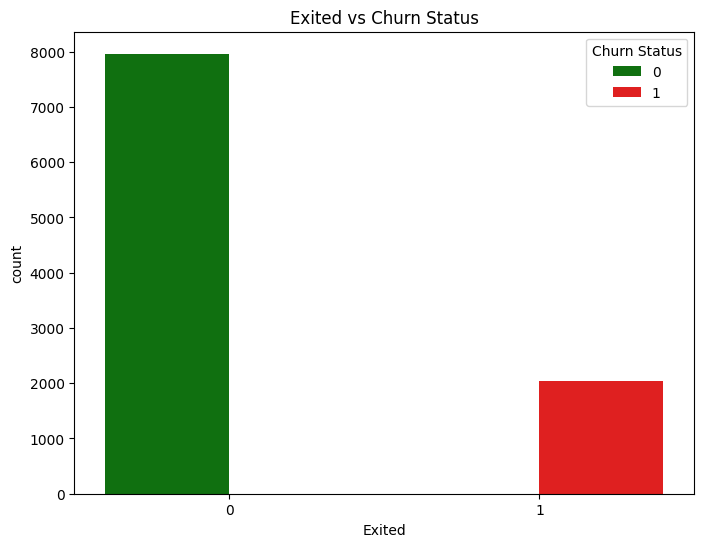

In [0]:
#Análisis de variables categóricas vs Churn Status
categorical_var = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
for var in categorical_var:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var, hue="Exited", palette=["green", "red"])
    plt.title(f"{var} vs Churn Status")
    plt.legend(title="Churn Status", loc="upper right")
    plt.show()

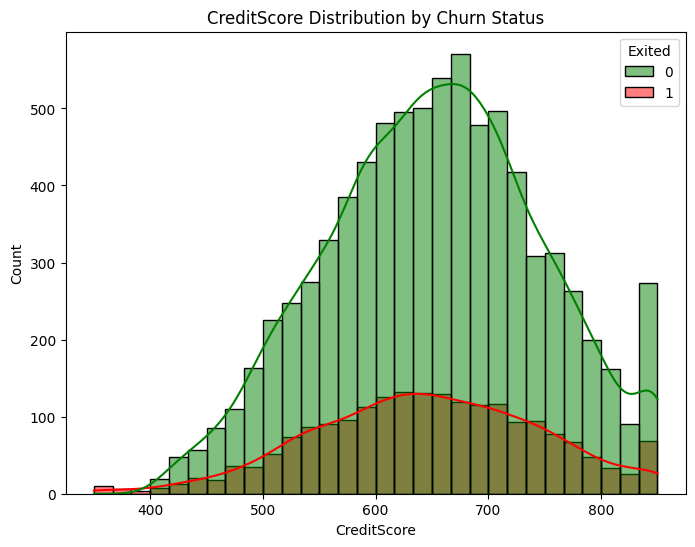

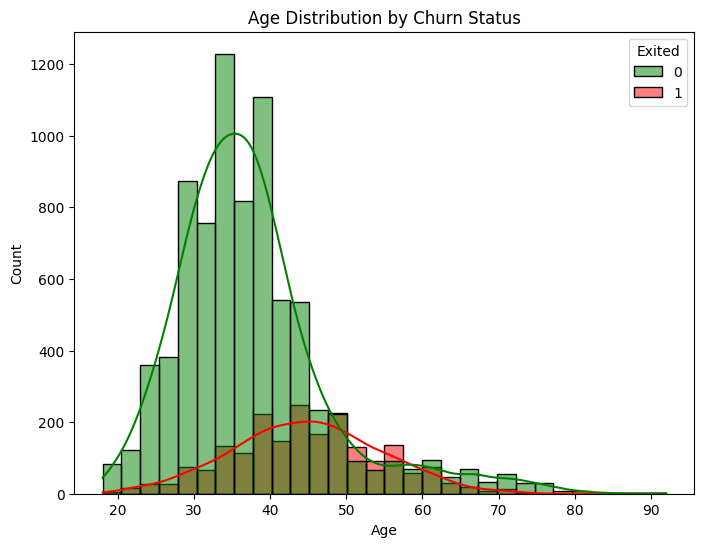

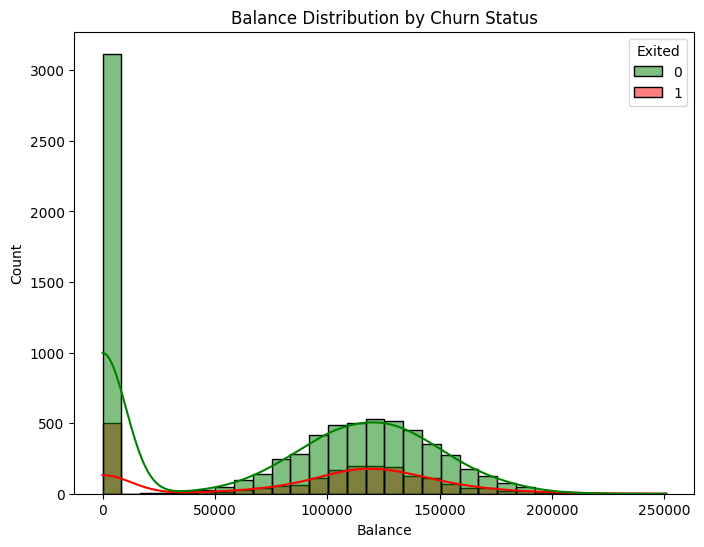

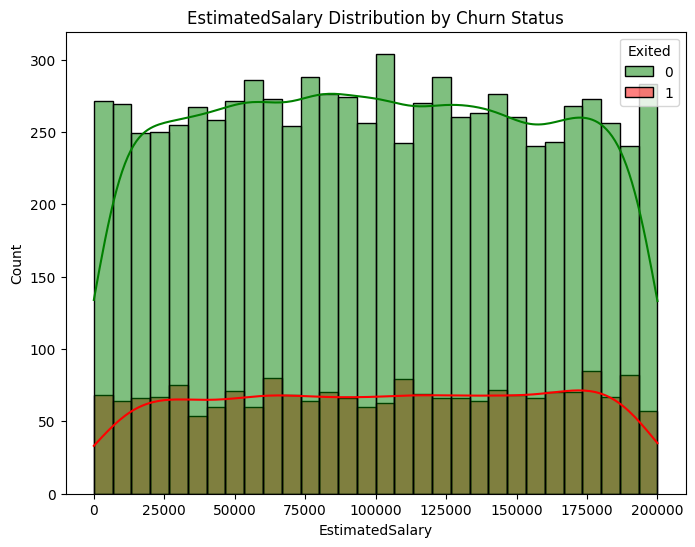

In [0]:
#Análisis de variables continuas vs Churn Status
continuous_var = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for var in continuous_var:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=var, hue="Exited", bins=30, kde=True, palette=["green", "red"])
    plt.title(f"{var} Distribution by Churn Status")
    plt.show()

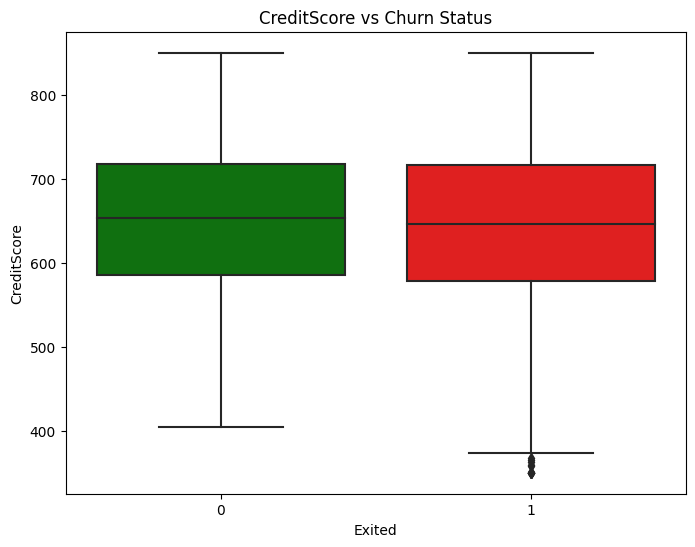

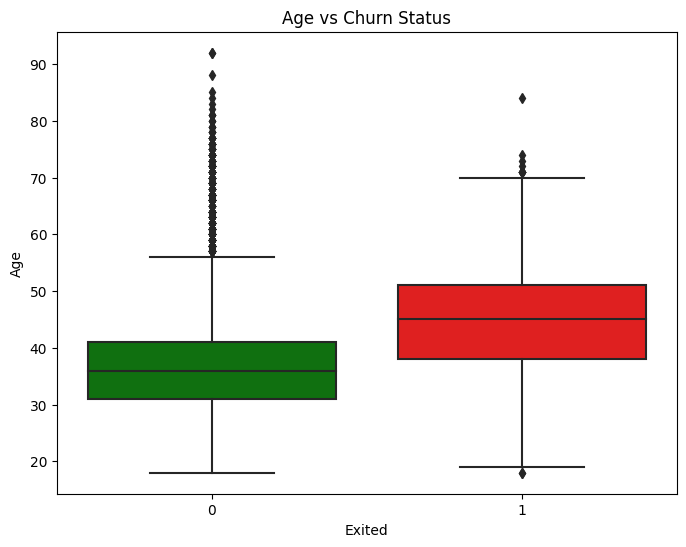

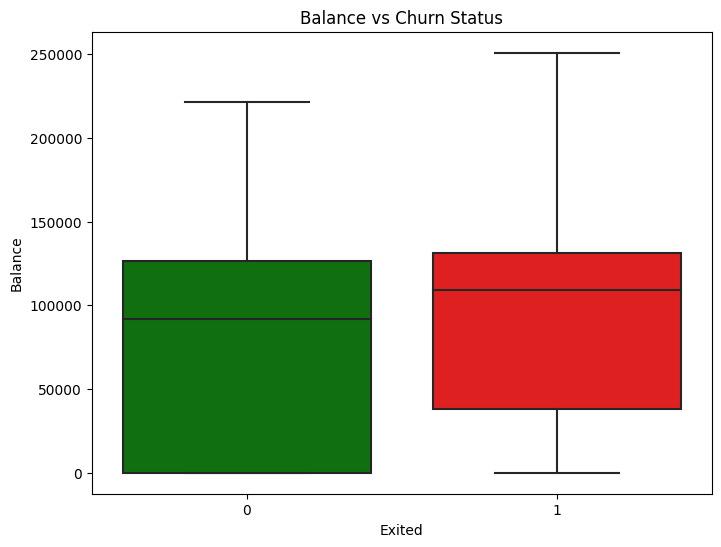

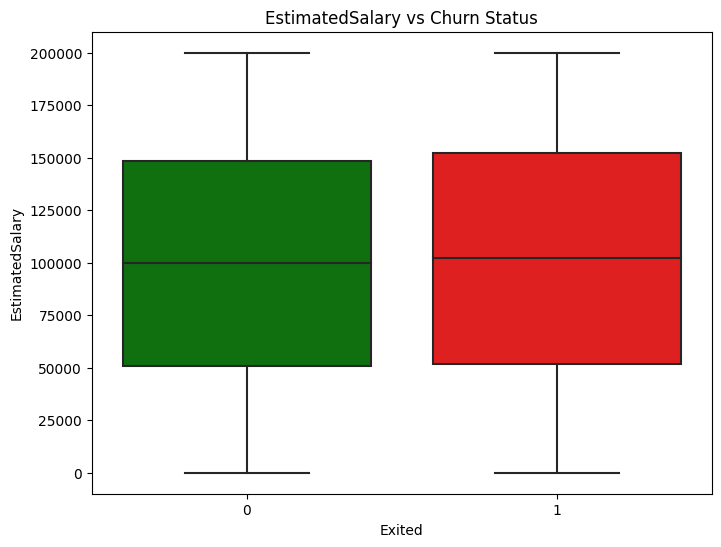

In [0]:
# Boxplots de variables continuas. 
for var in continuous_var:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x="Exited", y=var, palette=["green", "red"])
    plt.title(f"{var} vs Churn Status")
    plt.show()

### Data Preprocessing

In [0]:
# Codificar variables categóricas (One Hot Encoding)
df = pd.get_dummies(df, columns=["Geography", "Gender"])

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int32  
 1   Age                10000 non-null  int32  
 2   Tenure             10000 non-null  int32  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int32  
 5   HasCrCard          10000 non-null  int32  
 6   IsActiveMember     10000 non-null  int32  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int32  
 9   Geography_France   10000 non-null  uint8  
 10  Geography_Germany  10000 non-null  uint8  
 11  Geography_Spain    10000 non-null  uint8  
 12  Gender_Female      10000 non-null  uint8  
 13  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int32(7), uint8(5)
memory usage: 478.6 KB


In [0]:
df.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,0,1,0,1
6,822,50,7,0.00,2,1,1,10062.80,0,1,0,0,0,1
7,376,29,4,115046.74,4,1,0,119346.88,1,0,1,0,1,0
8,501,44,4,142051.07,2,0,1,74940.50,0,1,0,0,0,1
9,684,27,2,134603.88,1,1,1,71725.73,0,1,0,0,0,1


###Train Test Data Split

In [0]:
# Dividir datos en conjuntos de entrenaimento y prueba
X = df.drop("Exited", axis=1)
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [0]:
# Estandarización de los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###Model Training 

In [0]:
#Random Forest
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print(f'Random Forest Classification Report: \n {classification_report(y_test, rf_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run melodic-zebra-123 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/20ae8eb3ce2c4e2b9c609b4cb4e25ad4
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.77      0.49      0.60       611

    accuracy                           0.87      3000
   macro avg       0.83      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



In [0]:
#XGBoost
#xg_model = XGBClassifier(scale_pos_weight=4, random_state=123)
xg_model = XGBClassifier(random_state=123)
xg_model.fit(X_train_scaled, y_train)
xg_pred = xg_model.predict(X_test_scaled)

print(f'XGBoost Classification Report:: \n {classification_report(y_test, xg_pred)}')

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run efficient-fowl-335 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/ee91c18ba65541c1bbec2619faa7c25b
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
XGBoost Classification Report:: 
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      2389
           1       0.71      0.51      0.60       611

    accuracy                           0.86      3000
   macro avg       0.80      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000



In [0]:
#SVM 
svm_model = svm.SVC(random_state=123)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
print(f'Support Vector Machine Classification Report: \n {classification_report(y_test, svm_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rare-lynx-187 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/f20008c81dad4940a625d6af433a3907
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Support Vector Machine Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.81      0.41      0.55       611

    accuracy                           0.86      3000
   macro avg       0.84      0.69      0.73      3000
weighted avg       0.85      0.86      0.84      3000



In [0]:
#Regresión Logística 
lr_model = LogisticRegression(random_state=123)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

print(f'Logistic Regression Classification Report: \n {classification_report(y_test, lr_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run debonair-seal-522 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/10eb373a75f14e1fb1c27cb8ffd008b4
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      2389
           1       0.55      0.22      0.31       611

    accuracy                           0.80      3000
   macro avg       0.69      0.59      0.60      3000
weighted avg       0.77      0.80      0.77      3000



In [0]:
print(f'Random Forest AUC:', roc_auc_score(y_test, rf_pred))
print(f'Logistic Regression AUC:', roc_auc_score(y_test, lr_pred))
print(f'SVM AUC:', roc_auc_score(y_test, svm_pred))
print(f'XGBoost AUC:', roc_auc_score(y_test, xg_pred))

Random Forest AUC: 0.7282995096867187
Logistic Regression AUC: 0.5870338615544926
SVM AUC: 0.6944800877453193
XGBoost AUC: 0.7305849436759726


### Model Training (balanced dataset)

In [0]:
#Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=123)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print(f'Random Forest Classification Report: \n {classification_report(y_test, rf_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-pug-539 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/026c3cf2ed174aa484d90749d0ea326c
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.78      0.45      0.57       611

    accuracy                           0.86      3000
   macro avg       0.83      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



In [0]:
#XGBoost
xg_model = XGBClassifier(scale_pos_weight=4, random_state=123)
xg_model.fit(X_train_scaled, y_train)
xg_pred = xg_model.predict(X_test_scaled)

print(f'XGBoost Classification Report:: \n {classification_report(y_test, xg_pred)}')

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run aged-sponge-458 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/ccf1d01c4a464e6785898d9a90d95c78
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
XGBoost Classification Report:: 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2389
           1       0.57      0.65      0.61       611

    accuracy                           0.83      3000
   macro avg       0.74      0.76      0.75      3000
weighted avg       0.84      0.83      0.83      3000



In [0]:
#SVM 
svm_model = svm.SVC(class_weight='balanced', random_state=123)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
print(f'Support Vector Machine Classification Report: \n {classification_report(y_test, svm_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run suave-mare-794 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/abb46e29d17747e99a3f68bbab9d4d60
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Support Vector Machine Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.81      0.86      2389
           1       0.50      0.75      0.60       611

    accuracy                           0.79      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       0.84      0.79      0.81      3000



In [0]:
#Regresión Logística 
lr_model = LogisticRegression(class_weight='balanced', random_state=123)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

print(f'Logistic Regression Classification Report: \n {classification_report(y_test, lr_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run redolent-smelt-640 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/406b4bd8012947b4bf89e4775c530c70
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.71      0.79      2389
           1       0.38      0.68      0.48       611

    accuracy                           0.70      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.70      0.73      3000



In [0]:
print(f'Random Forest AUC:', roc_auc_score(y_test, rf_pred))
print(f'Logistic Regression AUC:', roc_auc_score(y_test, lr_pred))
print(f'SVM AUC:', roc_auc_score(y_test, svm_pred))
print(f'XGBoost AUC:', roc_auc_score(y_test, xg_pred))

Random Forest AUC: 0.7083163490055004
Logistic Regression AUC: 0.6951953134901578
SVM AUC: 0.7782926931195147
XGBoost AUC: 0.7630982565344847


### Model Training (balanced dataset SMOTE)

In [0]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Balancear el dataset
smote = SMOTE(random_state=123)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Estandarización de los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run stylish-crab-210 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/ee011852b20243debce25c02407f253a
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820


In [0]:
#Random Forest
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train_scaled, y_train_balanced)
rf_pred = rf_model.predict(X_test_scaled)

print(f'Random Forest Classification Report: \n {classification_report(y_test, rf_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run industrious-ape-894 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/7d6cfeefd3244cee9feeee0a7c0a203a
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      2389
           1       0.65      0.59      0.62       611

    accuracy                           0.85      3000
   macro avg       0.77      0.75      0.76      3000
weighted avg       0.85      0.85      0.85      3000



In [0]:
#Regresión Logística 
lr_model = LogisticRegression(random_state=123)
lr_model.fit(X_train_scaled, y_train_balanced)
lr_pred = lr_model.predict(X_test_scaled)

print(f'Logistic Regression Classification Report: \n {classification_report(y_test, lr_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run upset-mink-71 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/41ec1d9269a748968a7e906538d641bf
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      2389
           1       0.50      0.43      0.46       611

    accuracy                           0.80      3000
   macro avg       0.68      0.66      0.67      3000
weighted avg       0.79      0.80      0.79      3000



In [0]:
#XGBoost
xg_model = XGBClassifier(random_state=123)
xg_model.fit(X_train_scaled, y_train_balanced)
xg_pred = xg_model.predict(X_test_scaled)

print(f'XGBoost Classification Report:: \n {classification_report(y_test, xg_pred)}')
#print("Confusion Matrix:")
#print(confusion_matrix(y_test, xg_pred))

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run rebellious-stork-142 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/ecc225375b9f41f7b5f3364f3adf7502
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
XGBoost Classification Report:: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      2389
           1       0.65      0.60      0.63       611

    accuracy                           0.85      3000
   macro avg       0.78      0.76      0.77      3000
weighted avg       0.85      0.85      0.85      3000



In [0]:
#SVM 
svm_model = svm.SVC(random_state=123)
svm_model.fit(X_train_scaled, y_train_balanced)
svm_pred = svm_model.predict(X_test_scaled)
print(f'Support Vector Machine Classification Report: \n {classification_report(y_test, svm_pred)}')

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unruly-croc-177 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/435136844e1c4927876a7b9b63f564bd
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Support Vector Machine Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2389
           1       0.66      0.56      0.60       611

    accuracy                           0.85      3000
   macro avg       0.77      0.74      0.76      3000
weighted avg       0.84      0.85      0.85      3000



In [0]:
print(f'Random Forest AUC:', roc_auc_score(y_test, rf_pred))
print(f'Logistic Regression AUC:', roc_auc_score(y_test, lr_pred))
print(f'SVM AUC:', roc_auc_score(y_test, svm_pred))
print(f'XGBoost AUC:', roc_auc_score(y_test, xg_pred))

Random Forest AUC: 0.7531590849769024
Logistic Regression AUC: 0.6599677052283413
SVM AUC: 0.7415873627009774
XGBoost AUC: 0.7597245695800241


### Cross Validation

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [0]:
models = {
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123, use_label_encoder=False), 
    "SVM": svm.SVC(random_state=123)
    }

In [0]:
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Guardar resultados
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=123)),
        ('clf', model)
    ])
    
    # F1-score
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

    # AUC
    auc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')

    # Recall
    recall_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
    
    # Promedios
    results[name] = {
        'F1-CV mean': round(np.mean(f1_scores), 4),
        'F1-CV std': round(np.std(f1_scores), 4),
        'AUC-CV mean': round(np.mean(auc_scores), 4),
        'AUC-CV std': round(np.std(auc_scores), 4),
        'Recall-CV mean': round(np.mean(recall_scores), 4),
        'Recall-CV std': round(np.std(recall_scores), 4),
    }

# Mostrar resultados
for model, metrics in results.items():
    print(f"{model} → F1: {metrics['F1-CV mean']} ± {metrics['F1-CV std']}, AUC: {metrics['AUC-CV mean']} ± {metrics['AUC-CV std']}, Recall: {metrics['Recall-CV mean']} ± {metrics['Recall-CV std']}")


Random Forest → F1: 0.6067 ± 0.0174, AUC: 0.8468 ± 0.0126, Recall: 0.5994 ± 0.0347
XGBoost → F1: 0.5931 ± 0.0335, AUC: 0.8398 ± 0.0166, Recall: 0.5497 ± 0.0425
SVM → F1: 0.5778 ± 0.0089, AUC: 0.8348 ± 0.0115, Recall: 0.7037 ± 0.0317


### Model Evaluation

Random Forest and SVM give the highest results compared to the other models

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Balancear el dataset
smote = SMOTE(random_state=123)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Estandarización de los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-elk-567 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/140e3f2291d94058997a65c6ffa035fb
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820


In [0]:
#Random Forest
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train_scaled, y_train_balanced)
rf_pred = rf_model.predict(X_test_scaled)

print(f'Confusion Matrix:\n', confusion_matrix(y_test, rf_pred))

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run whimsical-lynx-565 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/4b67743efe194a148d578e0bf27a1407
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Confusion Matrix:
 [[2191  198]
 [ 251  360]]


In [0]:
#SVM 
svm_model = svm.SVC(random_state=123)
svm_model.fit(X_train_scaled, y_train_balanced)
svm_pred = svm_model.predict(X_test_scaled)
print(f'Confusion Matrix:\n', confusion_matrix(y_test, svm_pred))

Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run sedate-hawk-746 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/335039aa62804c748aef9dec0eb465e4
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
Confusion Matrix:
 [[2210  179]
 [ 270  341]]


### Hyperparameter Tuning

In [0]:
# Definir el modelo base
rf = RandomForestClassifier(random_state=123)

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
}

# Definir validación cruzada 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=2
)

# Ejecutar búsqueda
grid_search.fit(X_train_scaled, y_train_balanced)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Mejor puntaje
print("Mejor F1-score en validación cruzada:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run delightful-squid-871 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/ca2cfc5536764fc7955447dfe9571ce5
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
🏃 View run incongruous-newt-556 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/ce30b74c5e894384a71d39cd89f3618c
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
🏃 View run efficient-sow-230 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/255e206ea9664c6c93101631a38fdc53
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
🏃 View run gifted-moose-453 at: https://community.cloud.databricks.com/ml/experiments/3445635906954820/runs/28c8360ecc4d422a8e518844c2873890
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3445635906954820
🏃 View run useful-snake-747 at: https://community.cloud